**GE SETUP 1**



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os.path

PATH = '/content/drive/MyDrive/grape/'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/UL-BDS/grape.git
    print('Cloning grape in your Drive')

%cd /content/drive/MyDrive/grape/

grape directory already exists
/content/drive/MyDrive/grape


In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install deap

import grape
import algorithms
from functions import not_, and_, or_, nand_, nor_

from os import path
import pandas as pd
import numpy as np
from deap import creator, base, tools

import random
import matplotlib.pyplot as plt

In [26]:
POPULATION_SIZE = 500
MAX_GENERATIONS = 50
P_CROSSOVER = 0.7
P_MUTATION = 0.01
ELITE_SIZE = round(0.02*POPULATION_SIZE)
HALLOFFAME_SIZE = round(0.02*POPULATION_SIZE)

CODON_CONSUMPTION = 'lazy'
GENOME_REPRESENTATION = 'list'
MAX_GENOME_LENGTH = None

MAX_INIT_TREE_DEPTH = 13
MIN_INIT_TREE_DEPTH = 3
MAX_TREE_DEPTH = 35
MAX_WRAPS = 0
CODON_SIZE = 255

REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth','max_length'
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']

In [27]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [28]:
problem = 'parity4'

In [29]:
if  problem == 'parity4':
    X_train = np.zeros([4,16], dtype=bool)
    Y_train = np.zeros([16,], dtype=bool)

    data = pd.read_table(r"datasets/parity4.csv")
    for i in range(4):
        for j in range(16):
            X_train[i,j] = data['d'+ str(i)].iloc[j]
    for i in range(16):
        Y_train[i] = data['output'].iloc[i]

    GRAMMAR_FILE = 'parity4.bnf'

In [30]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(data)

,d0,d1,d2,d3,output
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,1,1,1
4,0,1,0,0,0
5,0,1,0,1,1
6,0,1,1,0,1
7,0,1,1,1,0
8,1,0,0,0,0
9,1,0,0,1,1


In [31]:
f = open("grammars/" + GRAMMAR_FILE, "r")
print(f.read())
f.close()

<e>  ::=  <op> | <x>
<op> ::=  and_(<e>,<e>)|
          or_(<e>,<e>)|
          nand_(<e>,<e>)|
          nor_(<e>,<e>)
<x> ::=   x[0]|x[1]|x[2]|x[3]


In [32]:
BNF_GRAMMAR = grape.Grammar(path.join("grammars", GRAMMAR_FILE))

In [33]:
# minimizing the error - returning the no of outputs wrongly predicted
def fitness_eval(individual, points):
    x = points[0]
    Y = points[1]

    if individual.invalid == True:
        return np.NaN,

    # Evaluate the expression
    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError):
        # FP err can happen through eg overflow (lots of pow/exp calls)
        # ZeroDiv can happen when using unprotected operators
        return np.NaN,
    assert np.isrealobj(pred)

    # The expected outputs are in Y
    n_samples = len(Y)
    compare = np.equal(Y,pred) # Compare the outputs with the expected values
    n_correct_outputs = np.sum(compare)

    fitness = n_samples - n_correct_outputs

    return fitness,

In [34]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', grape.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", grape.sensible_initialisation, creator.Individual)
#toolbox.register("populationCreator", grape.random_initialisation, creator.Individual)

toolbox.register("evaluate", fitness_eval)

# Tournament selection:
toolbox.register("select", tools.selTournament, tournsize=6)

# Single-point crossover:
toolbox.register("mate", grape.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", grape.mutation_int_flip_per_codon)

In [35]:
# create initial population (generation 0):
population = toolbox.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR,
                                      min_init_depth=MIN_INIT_TREE_DEPTH,
                                      max_init_depth=MAX_INIT_TREE_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                      )

# define the hall-of-fame object:
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                              bnf_grammar=BNF_GRAMMAR,
                                              codon_size=CODON_SIZE,
                                              max_tree_depth=MAX_TREE_DEPTH,
                                              max_genome_length=MAX_GENOME_LENGTH,
                                              points_train=[X_train, Y_train],
                                              codon_consumption=CODON_CONSUMPTION,
                                              report_items=REPORT_ITEMS,
                                              genome_representation=GENOME_REPRESENTATION,
                                              stats=stats, halloffame=hof, verbose=False)

gen = 0 , Best fitness = (6.0,)
gen = 1 , Best fitness = (6.0,) , Number of invalids = 76
gen = 2 , Best fitness = (5.0,) , Number of invalids = 33
gen = 3 , Best fitness = (5.0,) , Number of invalids = 23
gen = 4 , Best fitness = (4.0,) , Number of invalids = 12
gen = 5 , Best fitness = (4.0,) , Number of invalids = 12
gen = 6 , Best fitness = (4.0,) , Number of invalids = 12
gen = 7 , Best fitness = (3.0,) , Number of invalids = 12
gen = 8 , Best fitness = (3.0,) , Number of invalids = 6
gen = 9 , Best fitness = (3.0,) , Number of invalids = 8
gen = 10 , Best fitness = (3.0,) , Number of invalids = 4
gen = 11 , Best fitness = (3.0,) , Number of invalids = 3
gen = 12 , Best fitness = (3.0,) , Number of invalids = 7
gen = 13 , Best fitness = (3.0,) , Number of invalids = 6
gen = 14 , Best fitness = (3.0,) , Number of invalids = 3
gen = 15 , Best fitness = (2.0,) , Number of invalids = 3
gen = 16 , Best fitness = (2.0,) , Number of invalids = 1
gen = 17 , Best fitness = (2.0,) , Number 

In [36]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")

best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")

selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")
avg_used_codons = logbook.select("avg_used_codons")
best_ind_used_codons = logbook.select("best_ind_used_codons")

best_ind_nodes = logbook.select("best_ind_nodes")
avg_nodes = logbook.select("avg_nodes")

avg_depth = logbook.select("avg_depth")

header = REPORT_ITEMS

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values,
                                min_fitness_values, max_fitness_values,
                                best_ind_length, avg_length,
                                best_ind_nodes, avg_nodes,
                                avg_depth,
                                avg_used_codons, best_ind_used_codons,
                                selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,max_lengthavg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,0,8.000000,0.497996,6.0,10.0,189,102.240000,32,17.540000,9.028000,68.160000,126,0.000000,0.076559
1,1,76,7.775943,0.569911,6.0,10.0,189,138.742925,32,17.250000,10.867925,67.000000,126,0.003324,0.355373
2,2,33,7.535332,0.754951,5.0,10.0,231,177.286938,27,22.903640,14.353319,89.614561,106,0.003346,0.470970
3,3,23,7.454927,0.854487,5.0,10.0,231,203.997904,27,24.855346,15.813417,97.421384,106,0.003361,0.575771
4,4,12,7.413934,0.975505,4.0,10.0,231,215.706967,27,26.540984,16.778689,104.163934,106,0.003308,0.615610
5,5,12,7.219262,1.055372,4.0,10.0,231,228.510246,27,27.592213,17.036885,108.368852,106,0.003479,0.562039
6,6,12,7.155738,1.219853,4.0,10.0,231,238.944672,27,28.555328,17.729508,112.221311,106,0.005394,0.637180
7,7,12,7.110656,1.308879,3.0,12.0,172,250.690574,19,28.715164,17.500000,112.860656,74,0.003735,0.681687
8,8,6,7.018219,1.304644,3.0,10.0,172,261.558704,19,28.194332,17.514170,110.777328,74,0.003448,0.632235
9,9,8,6.961382,1.435798,3.0,10.0,172,272.325203,19,29.758130,17.597561,117.032520,74,0.003306,0.704863


In [37]:
import textwrap
best = hof.items[0].phenotype
print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
print("\nTraining Fitness: ", hof.items[0].fitness.values[0])

print("Depth: ", hof.items[0].depth)
print("Length of the genome: ", len(hof.items[0].genome))
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

Best individual: 
 nand_(nor_(nor_(nor_(nor_(x[2],x[1]),and_(x[1],x[2])),nor_(nor_(x[0],x[3]),and_(
x[3],x[0]))),nor_(nand_(x[1],x[0]),or_(and_(x[1],x[3]),or_(and_(x[1],and_(x[1],x
[2])),nor_(x[0],x[2]))))),or_(nor_(or_(or_(x[2],nor_(x[1],x[0])),nor_(nand_(x[2]
,x[0]),or_(x[0],x[2]))),or_(nor_(and_(x[3],x[1]),and_(x[1],x[0])),or_(and_(x[1],
and_(x[1],x[2])),and_(x[0],nand_(or_(nand_(x[0],x[3]),and_(nor_(x[2],nor_(nand_(
or_(x[2],x[3]),nor_(x[0],x[0])),x[0])),nand_(x[3],x[3]))),x[0]))))),nand_(nor_(n
or_(x[2],x[1]),and_(x[1],x[2])),nor_(nor_(x[0],x[3]),and_(x[3],x[0])))))

Training Fitness:  1.0
Depth:  29
Length of the genome:  556
Used portion of the genome: 0.36


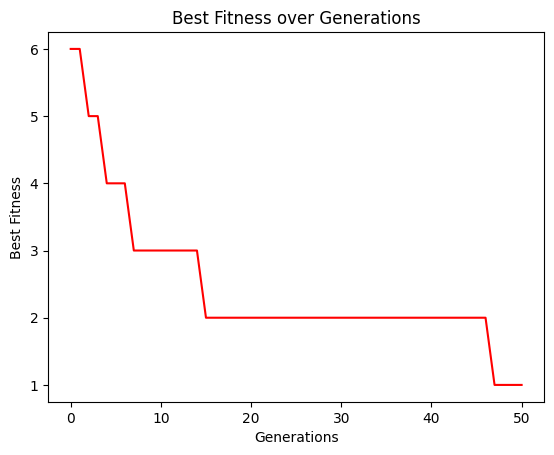

In [38]:
plt.plot(min_fitness_values, color='red')
plt.xlabel('Generations')
plt.ylabel('Best Fitness')
plt.title('Best Fitness over Generations')
plt.show()

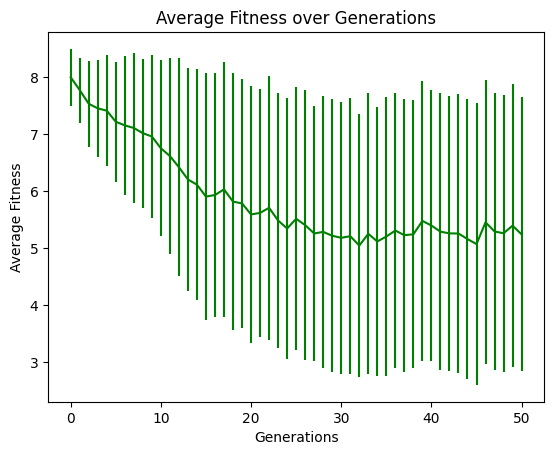

In [39]:
gen = np.arange(0, 50+1)

plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

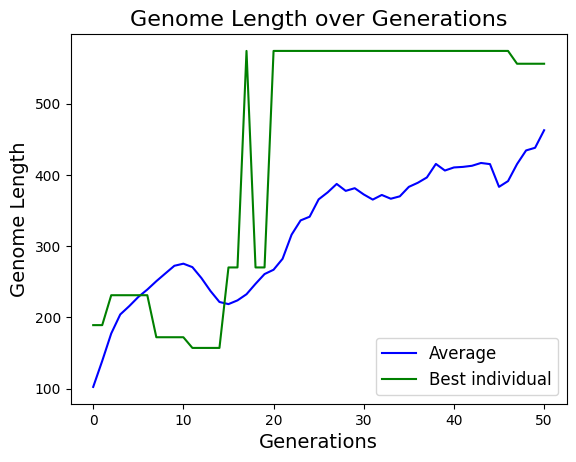

In [40]:
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()



**GP SETUP 1**

In [41]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [42]:
import operator
import math

import numpy

from deap import algorithms
from deap import gp

import itertools
import networkx as nx

In [43]:
# Genetic Programming constants:
POPULATION_SIZE = 500
MAX_GENERATIONS = 50
P_CROSSOVER = 0.7
P_MUTATION = 0.01

HALL_OF_FAME_SIZE = round(0.02*POPULATION_SIZE)

In [44]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

In [45]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

In [46]:
NUM_INPUTS = 4
NUM_COMBINATIONS = 2 ** NUM_INPUTS

In [47]:
# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []
for row in parityIn:
    parityOut.append(sum(row) % 2)

# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut))

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

In [48]:
def nor(x,y):
  return not(x or y)
def nand(x,y):
  return not(x and y)

# create the primitive set:
primitiveSet = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
primitiveSet.addPrimitive(operator.and_, 2)
primitiveSet.addPrimitive(operator.or_, 2)
primitiveSet.addPrimitive(nor, 2)
primitiveSet.addPrimitive(nand , 2)

# add terminal values:
primitiveSet.addTerminal(1)
primitiveSet.addTerminal(0)

In [49]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=primitiveSet, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=primitiveSet)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=6)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitiveSet)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

In [50]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [51]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

In [52]:
population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	500   	8  	0  	10 	7  	500   	0.316228	35.032	0  	63 	15 	500   	19.0964
1  	352   	7.824	1  	9  	7  	352   	0.411125	34.384	1  	93 	9  	352   	18.5788
2  	352   	7.54 	2  	10 	6  	352   	0.537029	36.876	2  	91 	9  	352   	19.6385
3  	333   	7.26 	3  	9  	6  	333   	0.52192 	43.168	3  	107	5  	333   	20.0456
4  	347   	7.16 	4  	9  	5  	347   	0.560714	45.604	4  	101	3  	347   	19.4096
5  	360   	7.014	5  	9  	5  	360   	0.696996	47.22 	5  	103	11 	360   	18.365 
6  	366   	6.628	6  	9  	5  	366   	0.760011	52.32 	6  	111	11 	366   	19.0318
7  	341   	6.282	7  	10 	5  	341   	0.801546	55.508	7  	105	19 	341   	17.4592
8  	337   	5.97 	8  	10 	4  	337   	0.867813	61.736	8  	109	17 	337   	15.310

operators used for setup1: and, or, nor, nand
-- Best Individual =  nor(or_(nor(nand(nor(in_1, 0), nand(in_0, 1)), nand(and_(in_3, in_2), nand(in_2, in_0))), and_(or_(and_(in_3, in_0), or_(and_(nand(nand(1, and_(or_(and_(nand(nand(1, in_0), in_3), in_3), 1), in_0)), in_3), in_3), nand(1, in_0))), nor(and_(nand(in_2, in_0), in_3), nand(in_2, in_1)))), and_(in_0, and_(and_(nor(0, and_(in_3, in_2)), nand(in_2, in_1)), and_(nand(in_1, in_3), or_(in_2, and_(or_(and_(in_1, in_3), in_0), nor(nor(in_2, 1), nor(in_1, and_(1, in_3)))))))))
-- length=85, height=13
-- Best Fitness =  2.0


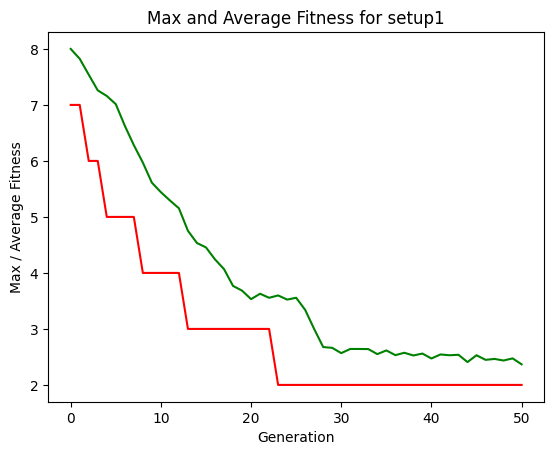

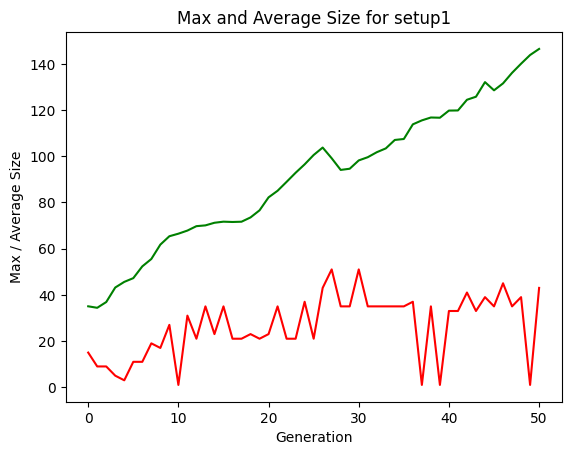

In [53]:
maxFitnessValues1, meanFitnessValues1 = logbook.chapters['fitness'].select("min", "avg")
maxsize1,avgsize1 = logbook.chapters['size'].select("min","avg")

# print info for best solution found:
best = hof.items[0]
print('operators used for setup1: and, or, nor, nand')
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues1, color='red')
plt.plot(meanFitnessValues1, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness for setup1')
plt.show()

plt.plot(maxsize1, color='red')
plt.plot(avgsize1, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Size')
plt.title('Max and Average Size for setup1')
plt.show()




**SETUP 1: GE and GP COMPARISON**

**Programming Constants: low mutation and crossover rates**
1. POPULATION_SIZE = 500
2. MAX_GENERATIONS = 50
3. P_CROSSOVER = 0.7
4. P_MUTATION = 0.01
5. HALL_OF_FAME_SIZE = 2% of population size (10)

**GE Output Parameters:**

1. Best individual:
nand_(nor_(nor_(nor_(nor_(x[2],x[1]),and_(x[1],x[2])),nor_(nor_(x[0],x[3]),and_(
x[3],x[0]))),nor_(nand_(x[1],x[0]),or_(and_(x[1],x[3]),or_(and_(x[1],and_(x[1],x
[2])),nor_(x[0],x[2]))))),or_(nor_(or_(or_(x[2],nor_(x[1],x[0])),nor_(nand_(x[2]
,x[0]),or_(x[0],x[2]))),or_(nor_(and_(x[3],x[1]),and_(x[1],x[0])),or_(and_(x[1],
and_(x[1],x[2])),and_(x[0],nand_(or_(nand_(x[0],x[3]),and_(nor_(x[2],nor_(nand_(
or_(x[2],x[3]),nor_(x[0],x[0])),x[0])),nand_(x[3],x[3]))),x[0]))))),nand_(nor_(n
or_(x[2],x[1]),and_(x[1],x[2])),nor_(nor_(x[0],x[3]),and_(x[3],x[0])))))


2. Training Fitness:  1.0
3. Depth:  29
4. Length of the genome:  556 And  Used portion of the genome: 0.36
5. Size of codon / Effective Length used for Best Individual => 556*0.36 = 200

**GP Output Parameters:**

1. Best Individual =  nor(or_(nor(nand(nor(in_1, 0), nand(in_0, 1)), nand(and_(in_3, in_2), nand(in_2, in_0))), and_(or_(and_(in_3, in_0), or_(and_(nand(nand(1, and_(or_(and_(nand(nand(1, in_0), in_3), in_3), 1), in_0)), in_3), in_3), nand(1, in_0))), nor(and_(nand(in_2, in_0), in_3), nand(in_2, in_1)))), and_(in_0, and_(and_(nor(0, and_(in_3, in_2)), nand(in_2, in_1)), and_(nand(in_1, in_3), or_(in_2, and_(or_(and_(in_1, in_3), in_0), nor(nor(in_2, 1), nor(in_1, and_(1, in_3))))))))

2. Best Fitness =  2.0
3. height=13
4. GP model length for the best individual =85

It is observed that GE achieves convergence faster / gets a minimum best fitness of 1 at 47th generation however the number of codons used and the height of the tree formed is higher compared to GP model .

While GP model could reach best fitness of only 2 for the same parameters used for GE and the length of the genome is much smaller (85) compared to GE and achieves the best fitness of 2 after a longer number of generations(in this case, at 38th generation as seen from the graph below) in comparison to GE which converged faster for fitness of 2.

Hence, the GE model performed better than GP in finding the best minimum fitness of 1.0 and at a lesser generation while using less number of genomes.
However the 2nd graph shows the average fitness over a number of generations performing better for GP than GE. It is also observed that low or medium crossover and mutation rates help GE model perform better.

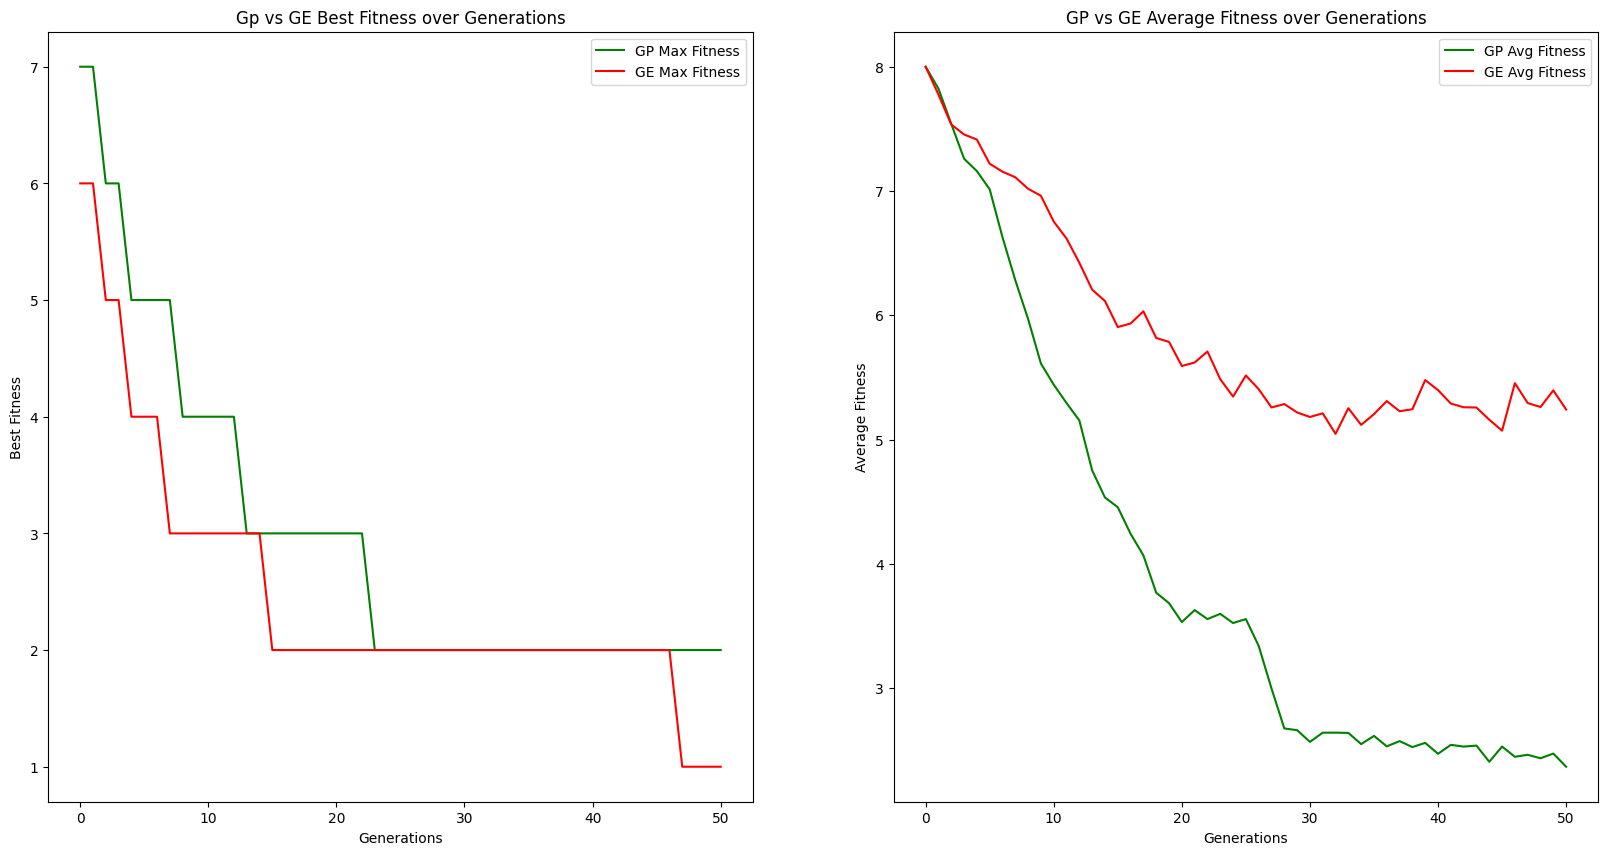

In [54]:
# GP vs GE max fitness value

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# GP Plot Setup 1
axs[0].plot(maxFitnessValues1, color='green', label='GP Max Fitness')
# GE plot setup 1
axs[0].plot(min_fitness_values, color='red', label = 'GE Max Fitness')

axs[0].set_xlabel('Generations')
axs[0].set_ylabel('Best Fitness')
axs[0].set_title('Gp vs GE Best Fitness over Generations')
axs[0].legend()

# GP
axs[1].plot(meanFitnessValues1, color='green', label='GP Avg Fitness')
# GE
axs[1].errorbar(gen,mean_fitness_values,label="GE Avg Fitness", color="red")

axs[1].set_xlabel('Generations')
axs[1].set_ylabel('Average Fitness')
axs[1].set_title('GP vs GE Average Fitness over Generations')
axs[1].legend()

plt.show()

**GE SETUP 2**

In [55]:
import grape
import algorithms
from functions import not_, and_, or_, nand_, nor_

from os import path
import pandas as pd
import numpy as np
from deap import creator, base, tools

import random
import matplotlib.pyplot as plt

In [56]:
POPULATION_SIZE = 500
MAX_GENERATIONS = 50
P_CROSSOVER = 0.8
P_MUTATION = 0.1
ELITE_SIZE = round(0.02*POPULATION_SIZE)
HALLOFFAME_SIZE = round(0.02*POPULATION_SIZE)

CODON_CONSUMPTION = 'lazy'
GENOME_REPRESENTATION = 'list'
MAX_GENOME_LENGTH = None

MAX_INIT_TREE_DEPTH = 13
MIN_INIT_TREE_DEPTH = 3
MAX_TREE_DEPTH = 35
MAX_WRAPS = 0
CODON_SIZE = 255

REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth','max_length'
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']

In [57]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [58]:
problem = 'parity4'

In [59]:
if  problem == 'parity4':
    X_train = np.zeros([4,16], dtype=bool)
    Y_train = np.zeros([16,], dtype=bool)

    data = pd.read_table(r"datasets/parity4.csv")
    for i in range(4):
        for j in range(16):
            X_train[i,j] = data['d'+ str(i)].iloc[j]
    for i in range(16):
        Y_train[i] = data['output'].iloc[i]

    GRAMMAR_FILE = 'parity4.bnf'

In [60]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(data)

,d0,d1,d2,d3,output
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,1,1,1
4,0,1,0,0,0
5,0,1,0,1,1
6,0,1,1,0,1
7,0,1,1,1,0
8,1,0,0,0,0
9,1,0,0,1,1


In [61]:
f = open("grammars/" + GRAMMAR_FILE, "r")
print(f.read())
f.close()

<e>  ::=  <op> | <x>
<op> ::=  and_(<e>,<e>)|
          or_(<e>,<e>)|
          nand_(<e>,<e>)|
          nor_(<e>,<e>)
<x> ::=   x[0]|x[1]|x[2]|x[3]


In [62]:
BNF_GRAMMAR = grape.Grammar(path.join("grammars", GRAMMAR_FILE))

In [63]:
# minimizing the error - returning the no of outputs wrongly predicted
def fitness_eval(individual, points):
    x = points[0]
    Y = points[1]

    if individual.invalid == True:
        return np.NaN,

    # Evaluate the expression
    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError):
        # FP err can happen through eg overflow (lots of pow/exp calls)
        # ZeroDiv can happen when using unprotected operators
        return np.NaN,
    assert np.isrealobj(pred)

    # The expected outputs are in Y
    n_samples = len(Y)
    compare = np.equal(Y,pred) # Compare the outputs with the expected values
    n_correct_outputs = np.sum(compare)

    fitness = n_samples - n_correct_outputs

    return fitness,

In [64]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', grape.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", grape.sensible_initialisation, creator.Individual)
#toolbox.register("populationCreator", grape.random_initialisation, creator.Individual)

toolbox.register("evaluate", fitness_eval)

# Tournament selection:
toolbox.register("select", tools.selTournament, tournsize=6)

# Single-point crossover:
toolbox.register("mate", grape.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", grape.mutation_int_flip_per_codon)

In [65]:
# create initial population (generation 0):
population = toolbox.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR,
                                      min_init_depth=MIN_INIT_TREE_DEPTH,
                                      max_init_depth=MAX_INIT_TREE_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                      )

# define the hall-of-fame object:
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                              bnf_grammar=BNF_GRAMMAR,
                                              codon_size=CODON_SIZE,
                                              max_tree_depth=MAX_TREE_DEPTH,
                                              max_genome_length=MAX_GENOME_LENGTH,
                                              points_train=[X_train, Y_train],
                                              codon_consumption=CODON_CONSUMPTION,
                                              report_items=REPORT_ITEMS,
                                              genome_representation=GENOME_REPRESENTATION,
                                              stats=stats, halloffame=hof, verbose=False)

gen = 0 , Best fitness = (6.0,)
gen = 1 , Best fitness = (6.0,) , Number of invalids = 82
gen = 2 , Best fitness = (6.0,) , Number of invalids = 63
gen = 3 , Best fitness = (6.0,) , Number of invalids = 34
gen = 4 , Best fitness = (6.0,) , Number of invalids = 24
gen = 5 , Best fitness = (6.0,) , Number of invalids = 17
gen = 6 , Best fitness = (5.0,) , Number of invalids = 18
gen = 7 , Best fitness = (5.0,) , Number of invalids = 22
gen = 8 , Best fitness = (5.0,) , Number of invalids = 31
gen = 9 , Best fitness = (5.0,) , Number of invalids = 19
gen = 10 , Best fitness = (5.0,) , Number of invalids = 20
gen = 11 , Best fitness = (5.0,) , Number of invalids = 23
gen = 12 , Best fitness = (5.0,) , Number of invalids = 17
gen = 13 , Best fitness = (5.0,) , Number of invalids = 19
gen = 14 , Best fitness = (5.0,) , Number of invalids = 13
gen = 15 , Best fitness = (5.0,) , Number of invalids = 20
gen = 16 , Best fitness = (5.0,) , Number of invalids = 15
gen = 17 , Best fitness = (5.0,) 

In [66]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")

best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")

selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")
avg_used_codons = logbook.select("avg_used_codons")
best_ind_used_codons = logbook.select("best_ind_used_codons")

best_ind_nodes = logbook.select("best_ind_nodes")
avg_nodes = logbook.select("avg_nodes")

avg_depth = logbook.select("avg_depth")

header = REPORT_ITEMS

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values,
                                min_fitness_values, max_fitness_values,
                                best_ind_length, avg_length,
                                best_ind_nodes, avg_nodes,
                                avg_depth,
                                avg_used_codons, best_ind_used_codons,
                                selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,max_lengthavg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,0,8.000000,0.497996,6.0,10.0,189,102.240000,32,17.540000,9.028000,68.160000,126,0.000000,0.073705
1,1,82,7.966507,0.441645,6.0,10.0,202,137.188995,14,12.523923,11.162679,48.095694,54,0.003261,0.376160
2,2,63,7.951945,0.463769,6.0,10.0,189,161.395881,34,11.956522,11.942792,45.826087,134,0.004382,0.341210
3,3,34,7.924893,0.516615,6.0,10.0,222,178.708155,13,12.287554,12.686695,47.150215,50,0.003315,0.381380
4,4,24,7.932773,0.493335,6.0,10.0,222,186.598739,13,12.113445,13.130252,46.453782,50,0.003348,0.398749
5,5,17,7.937888,0.526987,6.0,10.0,222,201.006211,13,13.322981,13.766046,51.291925,50,0.003640,0.399848
6,6,18,7.927386,0.551231,5.0,9.0,189,205.213693,33,12.500000,13.452282,48.000000,130,0.003287,0.389532
7,7,22,7.924686,0.566293,5.0,10.0,189,210.453975,33,12.935146,14.100418,49.740586,130,0.003326,0.520864
8,8,31,7.953092,0.578521,5.0,10.0,189,217.673774,33,13.654584,14.458422,52.618337,130,0.003346,0.448074
9,9,19,7.956341,0.543499,5.0,10.0,189,210.812890,33,12.413721,14.039501,47.654886,130,0.003397,0.432651


In [67]:
import textwrap
best = hof.items[0].phenotype
print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
print("\nTraining Fitness: ", hof.items[0].fitness.values[0])

print("Depth: ", hof.items[0].depth)
print("Length of the genome: ", len(hof.items[0].genome))
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

Best individual: 
 nand_(nor_(and_(nor_(nor_(x[2],x[1]),and_(x[1],x[2])),nor_(nor_(x[0],x[3]),and_(
x[0],x[3]))),and_(nor_(nand_(x[1],x[1]),x[2]),nor_(x[1],or_(x[1],x[2])))),or_(or
_(x[0],x[3]),and_(x[0],nor_(and_(nand_(nor_(x[1],x[2]),nor_(x[0],x[0])),nand_(an
d_(x[3],or_(x[2],x[1])),and_(x[1],x[2]))),nor_(nor_(x[0],x[3]),and_(x[0],x[3])))
)))

Training Fitness:  4.0
Depth:  19
Length of the genome:  273
Used portion of the genome: 0.43


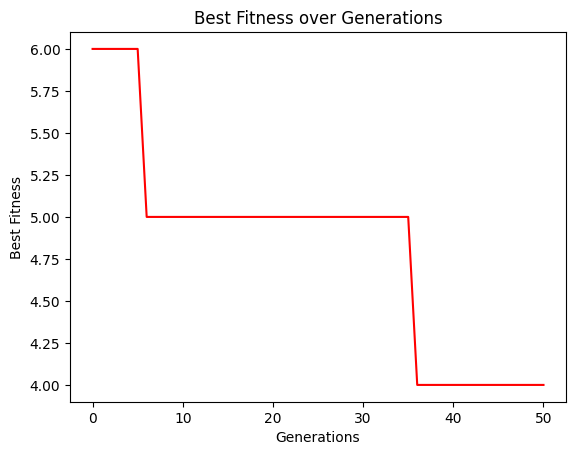

In [68]:
plt.plot(min_fitness_values, color='red')
plt.xlabel('Generations')
plt.ylabel('Best Fitness')
plt.title('Best Fitness over Generations')
plt.show()

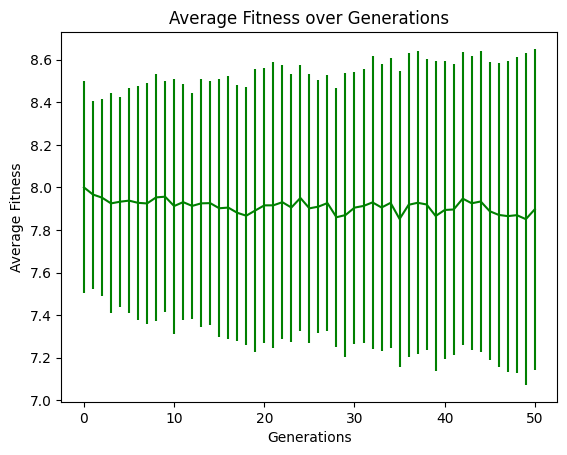

In [69]:
gen = np.arange(0, 50+1)

plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

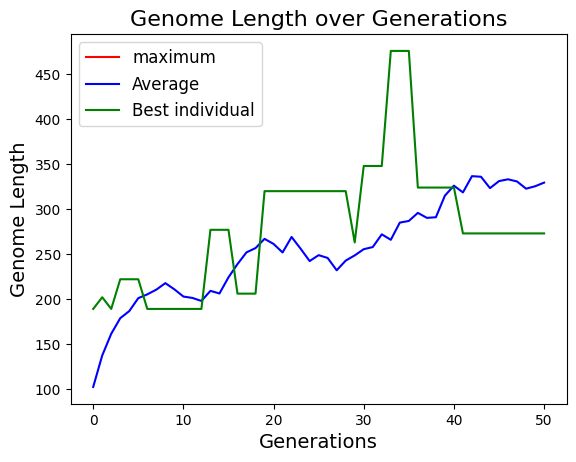

In [70]:
plt.plot(gen, max_length,color='red',label = 'maximum')
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()

**GP SETUP 2**

In [71]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import operator
import math

import numpy

from deap import algorithms
from deap import gp

import itertools
import networkx as nx

In [72]:
# Genetic Programming constants:
POPULATION_SIZE = 500
MAX_GENERATIONS = 50
P_CROSSOVER = 0.8
P_MUTATION = 0.1

HALL_OF_FAME_SIZE = round(0.02*POPULATION_SIZE)

In [73]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

In [74]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

In [75]:
NUM_INPUTS = 4
NUM_COMBINATIONS = 2 ** NUM_INPUTS

In [76]:
# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []
for row in parityIn:
    parityOut.append(sum(row) % 2)

# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut))

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

In [77]:
def nor(x,y):
  return not(x or y)
def nand(x,y):
  return not(x and y)

# create the primitive set:
primitiveSet = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
primitiveSet.addPrimitive(operator.and_, 2)
primitiveSet.addPrimitive(operator.or_, 2)
primitiveSet.addPrimitive(nor, 2)
primitiveSet.addPrimitive(nand , 2)

# add terminal values:
primitiveSet.addTerminal(1)
primitiveSet.addTerminal(0)

In [78]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=primitiveSet, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=primitiveSet)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=6)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitiveSet)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

In [79]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [80]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

In [81]:
population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	500   	8  	0  	10 	7  	500   	0.316228	35.032	0  	63 	15 	500   	19.0964
1  	415   	7.882	1  	9  	7  	415   	0.374267	34.272	1  	91 	1  	415   	18.5243
2  	413   	7.624	2  	9  	6  	413   	0.546465	38.856	2  	93 	1  	413   	19.219 
3  	395   	7.282	3  	9  	6  	395   	0.535235	46.812	3  	95 	1  	395   	18.7041
4  	412   	7.142	4  	9  	5  	412   	0.637053	49.176	4  	97 	1  	412   	18.0838
5  	413   	6.848	5  	9  	5  	413   	0.727252	54.724	5  	99 	13 	413   	16.7484
6  	425   	6.486	6  	10 	5  	425   	0.798626	60.948	6  	113	1  	425   	14.9159
7  	405   	6.174	7  	10 	4  	405   	0.804813	64.38 	7  	133	21 	405   	15.4818
8  	428   	5.954	8  	10 	4  	428   	1.00791 	67.296	8  	131	1  	428   	19.472

operators used for setup1: and, or, nor, nand
-- Best Individual =  nor(nor(nand(or_(nand(in_2, nand(or_(nand(in_2, in_1), and_(nand(or_(nor(nand(or_(nand(in_3, in_1), nor(1, and_(0, in_2))), nor(and_(nor(in_3, in_2), nor(or_(in_3, in_3), 1)), and_(0, in_2))), and_(or_(nor(in_0, in_2), nor(in_3, in_3)), nand(or_(in_1, in_2), in_0))), in_3), or_(in_1, 0)), in_1)), nand(in_3, nand(nand(or_(and_(nand(in_3, in_2), in_1), nor(in_3, and_(1, 1))), in_0), nand(in_0, or_(and_(nand(in_3, in_2), and_(1, in_1)), nor(or_(in_1, in_2), and_(1, 1)))))))), or_(nand(in_2, in_1), and_(0, or_(nand(in_2, in_1), and_(0, in_1))))), nand(in_3, nand(nand(in_2, in_0), nand(in_0, or_(and_(nand(in_3, in_2), and_(nand(nand(in_2, in_0), nand(in_0, or_(and_(nand(in_3, in_2), and_(1, in_1)), nor(or_(0, in_3), and_(1, 1))))), in_1)), nor(or_(0, in_3), and_(0, 1))))))), and_(and_(or_(nor(in_0, in_2), nor(in_3, in_1)), nand(or_(in_1, in_2), or_(nand(nand(in_2, in_0), nand(in_0, or_(and_(nand(in_3, in_2), in_3), nor(or_(

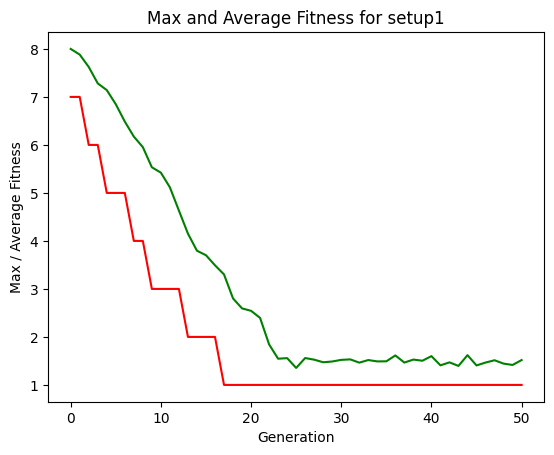

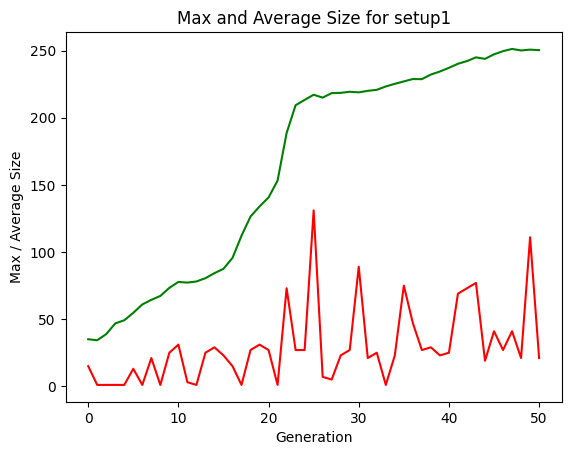

In [82]:
maxFitnessValues1, meanFitnessValues1 = logbook.chapters['fitness'].select("min", "avg")
maxsize1,avgsize1 = logbook.chapters['size'].select("min","avg")

# print info for best solution found:
best = hof.items[0]
print('operators used for setup1: and, or, nor, nand')
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues1, color='red')
plt.plot(meanFitnessValues1, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness for setup1')
plt.show()

plt.plot(maxsize1, color='red')
plt.plot(avgsize1, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Size')
plt.title('Max and Average Size for setup1')
plt.show()


**GE vs GP SETUP 2**

**Programming Constants: high mutation and crossover rate**
1. POPULATION_SIZE = 500
2. MAX_GENERATIONS = 50
3. P_CROSSOVER = 0.8
4. P_MUTATION = 0.1
5. HALL_OF_FAME_SIZE = 2 % of population size(10)

**GE Output Parameters:**

1. Best individual:
nand_(nor_(and_(nor_(nor_(x[2],x[1]),and_(x[1],x[2])),nor_(nor_(x[0],x[3]),and_(
x[0],x[3]))),and_(nor_(nand_(x[1],x[1]),x[2]),nor_(x[1],or_(x[1],x[2])))),or_(or
_(x[0],x[3]),and_(x[0],nor_(and_(nand_(nor_(x[1],x[2]),nor_(x[0],x[0])),nand_(an
d_(x[3],or_(x[2],x[1])),and_(x[1],x[2]))),nor_(nor_(x[0],x[3]),and_(x[0],x[3])))
)))

2. Best Fitness:  4.0
3. Depth:  19
4. Length of the genome:  273 And  Used portion of the genome: 0.43
5. Size of codon / Effective Length used for Best Individual => 273*0.43 = 117

**GP Output Parameters:**

1. Best Individual = nor(nor(nand(or_(nand(in_2, nand(or_(nand(in_2, in_1), and_(nand(or_(nor(nand(or_(nand(in_3, in_1), nor(1, and_(0, in_2))), nor(and_(nor(in_3, in_2), nor(or_(in_3, in_3), 1)), and_(0, in_2))), and_(or_(nor(in_0, in_2), nor(in_3, in_3)), nand(or_(in_1, in_2), in_0))), in_3), or_(in_1, 0)), in_1)), nand(in_3, nand(nand(or_(and_(nand(in_3, in_2), in_1), nor(in_3, and_(1, 1))), in_0), nand(in_0, or_(and_(nand(in_3, in_2), and_(1, in_1)), nor(or_(in_1, in_2), and_(1, 1)))))))), or_(nand(in_2, in_1), and_(0, or_(nand(in_2, in_1), and_(0, in_1))))), nand(in_3, nand(nand(in_2, in_0), nand(in_0, or_(and_(nand(in_3, in_2), and_(nand(nand(in_2, in_0), nand(in_0, or_(and_(nand(in_3, in_2), and_(1, in_1)), nor(or_(0, in_3), and_(1, 1))))), in_1)), nor(or_(0, in_3), and_(0, 1))))))), and_(and_(or_(nor(in_0, in_2), nor(in_3, in_1)), nand(or_(in_1, in_2), or_(nand(nand(in_2, in_0), nand(in_0, or_(and_(nand(in_3, in_2), in_3), nor(or_(0, in_3), and_(1, 1))))), nand(nand(or_(in_3, in_3), in_3), nand(in_2, in_1))))), nand(or_(in_1, in_2), and_(in_0, 1)))), nor(and_(nand(nor(in_1, in_2), or_(in_0, 1)), nand(or_(in_3, 0), and_(0, in_3))), or_(in_0, or_(or_(in_3, in_1), or_(0, 0)))))
2. Best Fitness =  1.0
3. height= 16
4. GP model length for the best individual = 219

In the second setup where crossover and mutation rates are higher, the GP model performs better than the GE model by achieving best minimum fitness of 1 while compared to GE model's best fitness of 4. We can say that GP converged faster however it used more no of nodes to achieve this fitness making the model individual more complex than GE model's structure.

The second graph shows the avg fitness of both the models, GP has the best avg fitness over GE.


-
Thus we are comparing the two models based on three factors,
1. Best minimum fitness/ convergence the models could achieve
2. The fastest generation it could achieve this fitness
3. The length of the tree strcture and the avg fitness of the model.

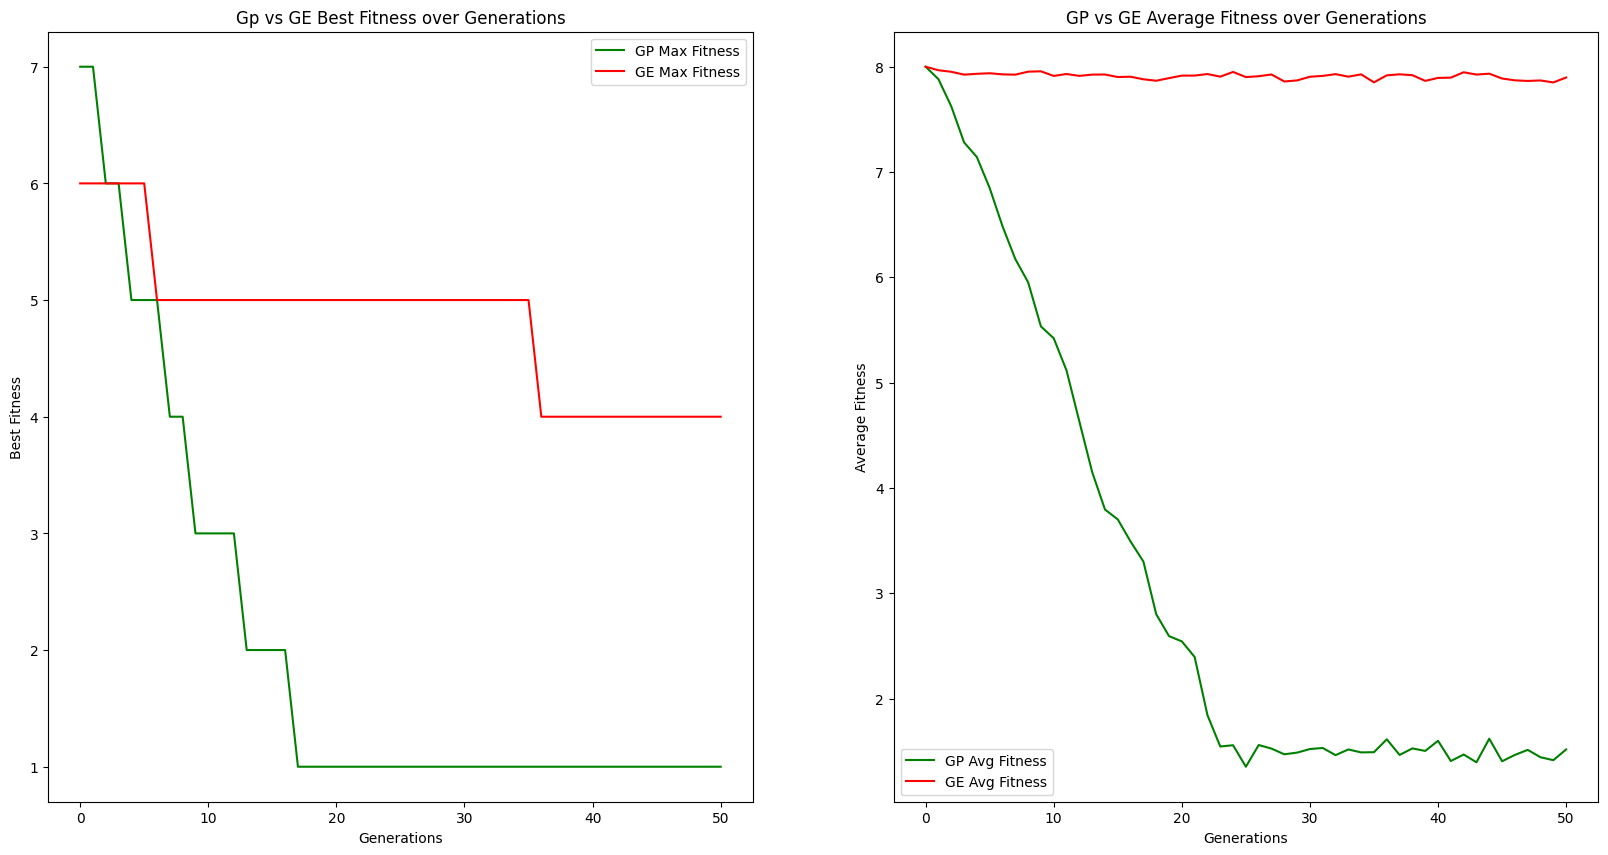

In [83]:
# GP vs GE max fitness value

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# GP Plot Setup 1
axs[0].plot(maxFitnessValues1, color='green', label='GP Max Fitness')
# GE plot setup 1
axs[0].plot(min_fitness_values, color='red', label = 'GE Max Fitness')

axs[0].set_xlabel('Generations')
axs[0].set_ylabel('Best Fitness')
axs[0].set_title('Gp vs GE Best Fitness over Generations')
axs[0].legend()

# GP
axs[1].plot(meanFitnessValues1, color='green', label='GP Avg Fitness')
# GE
axs[1].errorbar(gen,mean_fitness_values,label="GE Avg Fitness", color="red")

axs[1].set_xlabel('Generations')
axs[1].set_ylabel('Average Fitness')
axs[1].set_title('GP vs GE Average Fitness over Generations')
axs[1].legend()

plt.show()